## BIN 2021
# Evolutionary search of autoencoder architecture
* Author: Lukáš Dobiš
* Login: xdobis01
* Date: 5.5.2021

In [1]:
# Imports

import os
import copy
import random
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(2021)
random.seed(2021)
tf.random.set_seed(2021)

In [2]:
# Initializing tensorflow TPU support
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.26.176.122:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.26.176.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.26.176.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
# Loading FASHION-MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
# Model search space   
                                 # nb_fil  fil_siz  stride     
                                 # low,upp low,upp low,upp 
bounds = {"Encoder" : {"Layer1": [ (4,16), (3,7), (1,5)],
                       "Layer2": [ (2,5), (2,6), (1,3)]}
          ,
          "Decoder" : {"Layer1": [ (2,5), (2,6), (1,3)],
                       "Layer2": [ (4,16), (3,7), (1,5)]}
         }

In [5]:
# Architecture class containing model parameter initialization
class Architecture():
    def __init__(self, arch_parameters, param_bounds):
      self.current_loss = float('inf')
      self.parameters_for_csv = arch_parameters
      self.bounds = param_bounds
      self.encoder_layers = [{ "nb_filters" : layer[0],
                               "filter_size" : layer[1],
                               "stride" : layer[2]
                             } for layer in arch_parameters[0]]
      self.decoder_layers = [{ "nb_filters" : layer[0],
                               "filter_size" : layer[1],
                               "stride" : layer[2]
                             } for layer in arch_parameters[1]]
## EXAMPLE
# arch_params = [[[11,3,3],[3,2,1],[]],[]]
#

In [6]:
# Architecture initialization for population

def generateArchs(population_size, bounds):

  arch_configs = []

  # Initialize layers for population
  for coder_bounds in bounds.values():
    archs_coder = []
    for layer_bounds in coder_bounds.values():
      archs_layer = []
      for bound_down, bound_up in layer_bounds:
        archs_layer.append(np.random.randint(bound_down,bound_up,population_size))
      archs_coder.append(archs_layer)
    arch_configs.append(archs_coder)
  
  # Reshape to correct dimensions
  arch_configs = np.array(arch_configs) #[Enc/Dec,Layer,Param,Model]
  arch_configs = np.moveaxis(arch_configs,[3,0,1,2], [0, 1, 2, 3]).tolist() # [Model,Enc/Dec,Layer,Param]
  
  archs = [Architecture(arch_config, bounds) for arch_config in arch_configs]

  return archs

## EXAMPLE
#example_archs = generateArchs(4, bounds)

In [7]:
# Autoencoder whose parameters are initialized from architecture class object

class Autoencoder(Model):
  def __init__(self, arch):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential(
                                      [layers.Input(shape=(28, 28, 1))]
                                      + 
                                      [layers.Conv2D(int(layer["nb_filters"]), kernel_size=int(layer["filter_size"]), activation='relu', padding='same', strides=(int(layer["stride"]),int(layer["stride"]))) for layer in arch.encoder_layers]
                                      )
    self.decoder = tf.keras.Sequential(
                                      [layers.Conv2DTranspose(int(layer["nb_filters"]), kernel_size=int(layer["filter_size"]), activation='relu', padding='same', strides=(int(layer["stride"]),int(layer["stride"]))) for layer in arch.decoder_layers]
                                       +
                                      [layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')]
                                      )
    

    self.resize_output = tf.keras.layers.experimental.preprocessing.Resizing(
                            height=28, width=28, interpolation="bilinear", name=None
                         )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return self.resize_output(decoded)


## EXAMPLE
#for arch in ex_archs:
#  autoenc = Autoencoder(arch)
#  dec = autoenc(x_test)
#  arch.current_loss = tf.math.reduce_sum(tf.keras.losses.MSE(x_test, dec)).numpy()

In [8]:
# Binary tournament for architectures, winner is decided by architecture loss on validation data

def tournament(archs, number_parents):

  parents = []

  while(len(parents) < number_parents):
    parent_indices = random.sample(range(0, len(archs)), 2)
    arch_1 = archs[parent_indices[0]]
    arch_2 = archs[parent_indices[1]]
    winner = arch_1 if arch_1.current_loss < arch_2.current_loss else arch_2
    parents.append(winner)

  return parents

## EXAMPLE
#winners = tournament(ex_archs, 4)
#for winner in winners:
#  print(winner.current_loss)

In [9]:
# Offspring creation from parents, used in crossover

def make_offspring(parent_1, parent_2, enc_bitmask_len, dec_bitmask_len):
  
  bounds = parent_1.bounds
  
  mask = np.random.randint(2, size=enc_bitmask_len + dec_bitmask_len)

  index = 0
  offspring1 = []
  offspring2 = []
  
  for parent1_coder, parent2_coder in zip([parent_1.encoder_layers, parent_1.decoder_layers], [parent_2.encoder_layers, parent_2.decoder_layers]):
    
    offspring1_coder = []
    offspring2_coder = []
    
    for enc1_layer, enc2_layer in zip(parent1_coder, parent2_coder):
      
      offspring1_layer = []
      offspring2_layer = []
      
      for enc1_param, enc2_param in zip(enc1_layer.values(), enc2_layer.values()):
          offspring1_param, offspring2_param = (enc1_param, enc2_param) if mask[index] else (enc2_param, enc1_param)
          offspring1_layer.append(offspring1_param)
          offspring2_layer.append(offspring2_param)
          index+=1
      
      offspring1_coder.append(offspring1_layer)
      offspring2_coder.append(offspring2_layer)
    
    offspring1.append(offspring1_coder)
    offspring2.append(offspring2_coder)
  
  return [Architecture(offspring1, bounds), Architecture(offspring2, bounds)]

## EXAMPLE
#make_offspring(ex_archs[0], ex_archs[1], len(ex_archs[0].encoder_layers) * len(ex_archs[0].encoder_layers[0]), len(ex_archs[0].decoder_layers) * len(ex_archs[0].decoder_layers[0]))

In [10]:
# Crossover evolution operator for architecture object
def crossover(parents, crossover_prob):

  offspring = []

  parent_indices = random.sample(range(0, len(parents)), len(parents))
  parent_pairs = [parent_indices[i:i + 2] for i in range(0, len(parent_indices), 2)]
  
  encoder_bitmask_len = len(parents[0].encoder_layers) * len(parents[0].encoder_layers[0])
  decoder_bitmask_len = len(parents[0].decoder_layers) * len(parents[0].decoder_layers[0])

  for pair in parent_pairs:
    arch_1 = parents[pair[0]]
    arch_2 = parents[pair[1]]
    if random.uniform(0, 1) < crossover_prob:
      offspring.extend(make_offspring(arch_1,arch_2, encoder_bitmask_len, decoder_bitmask_len))
    else:
      offspring.extend([arch_1, arch_2])

  return offspring

## EXAMPLE
#crossover(ex_archs,0.9)

In [11]:
# Mutation evolution operator for architecture object

def mutation(archs, mutation_prob, mut_param):
  
  bounds = archs[0].bounds
  new_arch_configs = []
  for arch in archs:
    new_arch_config = []
    
    for coder, coder_bounds in zip([arch.encoder_layers, arch.decoder_layers], arch.bounds.values()):

      new_coder_layers = []
      for layer,layer_bounds in zip(coder, coder_bounds.values()):
        new_layer = []
        for old_param, param_bounds in zip(layer.values(), layer_bounds):

          if random.uniform(0, 1) < mutation_prob:
            u = random.uniform(0, 1)
            if u <= 0.5:
              param_lower_bound = param_bounds[0]
              new_param = round(old_param + ( (2*u)**(1/(1+mut_param)) - 1 )*(old_param - param_lower_bound))
            else:
              param_upper_bound = param_bounds[1]
              new_param = round(old_param + ( 1 - (2*(1 - u))**(1/(1+mut_param)) )*(param_upper_bound - old_param))
          else:
            new_param = old_param
          new_layer.append(new_param)
        new_coder_layers.append(new_layer)
      new_arch_config.append(new_coder_layers)
    new_arch_configs.append(new_arch_config)
    
  new_archs = [Architecture(arch_config, bounds) for arch_config in new_arch_configs]
  return new_archs

## EXAMPLE
#mutation(ex_archs, 0.1, 1.0)

In [12]:
# Evaluate architecture quality by training model from architecture, save MSE loss to architecture object

def testArchs(archs):

  for i,arch in enumerate(archs):
    
    print("ARCH: ", str(i+1))
    print("Old loss: " + str(arch.current_loss))

    with tpu_strategy.scope():
      model = Autoencoder(arch)
      model.compile(optimizer='adam', loss=losses.MeanSquaredError())
      model.fit(x_train, x_train,
                        epochs=4,
                        shuffle=True,
                        batch_size=256 * tpu_strategy.num_replicas_in_sync,
                        validation_data=(x_test, x_test))
    
      reconstrution = model(x_test)

      arch.current_loss = tf.math.reduce_sum(tf.keras.losses.MSE(x_test, reconstrution)).numpy()
      print("New loss: ", str(arch.current_loss))

  return archs

In [13]:
# Select best architectures from population

def selection(archs, number_selected):
  selected_archs = []

  archs = testArchs(archs)
  arch_losses = [arch.current_loss for arch in archs]

  order_archs = [archs[index] for index in np.argsort(arch_losses)]
  
  order_losses = [arch_losses[index] for index in np.argsort(arch_losses)]
  generation_average_loss = sum(order_losses[0:number_selected]) / number_selected
  
  return order_archs[0:number_selected], generation_average_loss

## EXAMPLE
#selection(ex_archs,4)

In [14]:
# Evolution algorithm
number_of_runs = 4

generations = 3

population_size = 4
number_parents = 2 # Atleast 2 parents
number_selected = 2
crossover_prob = 0.9
mutation_prob = 0.1
mut_param = 1.0

for run in range(number_of_runs):

  archs = generateArchs(population_size, bounds)
  archs, init_loss = selection(archs, number_selected)
  
  log_gen_loss = [init_loss]
  best_arch = copy.deepcopy(archs[0])

  gen_counter = 0
  while gen_counter < generations:

    parents = tournament(archs, number_parents)
    offspring = crossover(parents, crossover_prob)

    offspring = mutation(offspring, mutation_prob, mut_param)
    merged_archs = parents + offspring
    archs, gen_loss = selection(merged_archs, number_selected)

    if archs[0].current_loss < best_arch.current_loss:
      best_arch = copy.deepcopy(archs[0])

    print("RUN: " + str(run + 1))
    print("GENERATION: " + str(gen_counter + 1))
    print("Generation average loss: " + str(gen_loss))
    print("Generation best loss: " + str(archs[0].current_loss))
    print("RUN best loss: " + str(best_arch.current_loss))

    gen_counter += 1
    log_gen_loss.append(gen_loss)

  # Save generation vs loss performance
  df_gen_loss = pd.DataFrame(log_gen_loss)
  df_gen_loss.to_csv("RUN_" + str(run+1) + "_Generation_loss.csv")

  # Save best architecture

  df_params = pd.DataFrame([best_arch.parameters_for_csv])
  df_params.to_csv("RUN_" + str(run+1) + "_Best_architecture_parameters.csv")

ARCH:  1
Old loss: inf
Epoch 1/4
30/30 [==============================] - 10s 178ms/step - loss: 0.1691 - val_loss: 0.1626
Epoch 2/4
30/30 [==============================] - 1s 33ms/step - loss: 0.1596 - val_loss: 0.1423
Epoch 3/4
30/30 [==============================] - 1s 31ms/step - loss: 0.1331 - val_loss: 0.0974
Epoch 4/4
30/30 [==============================] - 1s 33ms/step - loss: 0.0838 - val_loss: 0.0535
New loss:  419162.34
ARCH:  2
Old loss: inf
Epoch 1/4
30/30 [==============================] - 10s 195ms/step - loss: 0.1684 - val_loss: 0.1592
Epoch 2/4
30/30 [==============================] - 1s 35ms/step - loss: 0.1544 - val_loss: 0.1311
Epoch 3/4
30/30 [==============================] - 1s 35ms/step - loss: 0.1229 - val_loss: 0.0990
Epoch 4/4
30/30 [==============================] - 1s 34ms/step - loss: 0.0932 - val_loss: 0.0780
New loss:  611485.6
ARCH:  3
Old loss: inf
Epoch 1/4
30/30 [==============================] - 9s 166ms/step - loss: 0.1690 - val_loss: 0.1611
Epo

## Tests

In [15]:
# Calculate average loss from each run best model

import ast

generations = 3
number_of_runs = 4
number_of_trainings = 3

best_archs_average_loss = []
best_archs_param_count = []

data_to_plot = np.empty((0,generations))
best = []

for run in range(number_of_runs):
  
  arch_losses = []
  
  gen_loss = pd.read_csv("RUN_" + str(run+1) + "_Generation_loss.csv").values[1:]
  gen_loss_np = np.array(gen_loss)[:,1]
  data_to_plot = np.concatenate((data_to_plot, gen_loss_np[None,:]),axis=0)

  arch_config_string = pd.read_csv("RUN_" + str(run+1) + "_Best_architecture_parameters.csv").values.tolist()
  arch_config_enc =  ast.literal_eval(arch_config_string[0][1])
  arch_config_dec =  ast.literal_eval(arch_config_string[0][2])
  arch_config = [arch_config_enc, arch_config_dec]

  best_arch = Architecture(arch_config, bounds)

  if not best:
     best = best = copy.deepcopy(best_arch)

  print("RUN: " + str(run+1))
  for training_counter in range(number_of_trainings):
    print("Training: " + str(training_counter + 1))
    with tpu_strategy.scope():
      model = Autoencoder(best_arch)
      model.compile(optimizer='adam', loss=losses.MeanSquaredError())
      model.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                batch_size=128 * tpu_strategy.num_replicas_in_sync,
                validation_data=(x_test, x_test))

      reconstruction = model.predict(x_test)
      arch_losses.append(tf.math.reduce_sum(tf.keras.losses.MSE(x_test, reconstruction)).numpy())
  
  best_arch.current_loss = np.average(arch_losses)
  best_archs_average_loss.append(best_arch.current_loss)
  best_archs_param_count.append(model.count_params())
  
  print("Number of parameters: " + str(best_archs_param_count[-1]))
  print("Average loss: " + str(best_archs_average_loss[-1]))
  print("Model summary :")
  model.encoder.summary()
  model.decoder.summary()


  if best_arch.current_loss  < best.current_loss:
     best = copy.deepcopy(best_arch)

print(best_archs_param_count)
df_params = pd.DataFrame(best_archs_param_count)
df_params.to_csv("Best_architectures_param_count.csv")

print(best_archs_average_loss)
df_params = pd.DataFrame(best_archs_average_loss)
df_params.to_csv("Best_architectures_losses.csv")

RUN: 1
Training: 1
Epoch 1/10
59/59 [==============================] - 10s 93ms/step - loss: 0.1624 - val_loss: 0.0875
Epoch 2/10
59/59 [==============================] - 1s 23ms/step - loss: 0.0653 - val_loss: 0.0375
Epoch 3/10
59/59 [==============================] - 1s 23ms/step - loss: 0.0350 - val_loss: 0.0295
Epoch 4/10
59/59 [==============================] - 1s 23ms/step - loss: 0.0282 - val_loss: 0.0254
Epoch 5/10
59/59 [==============================] - 2s 26ms/step - loss: 0.0246 - val_loss: 0.0229
Epoch 6/10
59/59 [==============================] - 1s 23ms/step - loss: 0.0225 - val_loss: 0.0214
Epoch 7/10
59/59 [==============================] - 1s 23ms/step - loss: 0.0211 - val_loss: 0.0204
Epoch 8/10
59/59 [==============================] - 1s 22ms/step - loss: 0.0201 - val_loss: 0.0196
Epoch 9/10
59/59 [==============================] - 1s 23ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 10/10
59/59 [==============================] - 1s 23ms/step - loss: 0.0189 - val_lo

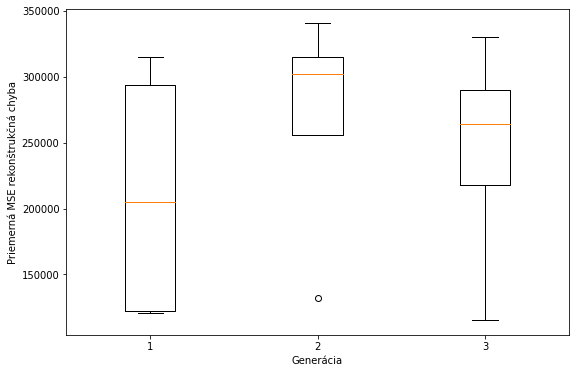

In [16]:
# Plot generation vs loss for each run in boxplot

fig_box = pl.figure(1, figsize=(9, 6))

ax = fig_box.add_subplot(111)

bp = ax.boxplot(data_to_plot)
ax.set_xlabel("Generácia")
ax.set_ylabel("Priemerná MSE rekonštrukčná chyba")
fig_box.savefig('Gen_loss_boxplot.png', bbox_inches='tight')

Epoch 1/10
59/59 [==============================] - 15s 167ms/step - loss: 0.1634 - val_loss: 0.1032
Epoch 2/10
59/59 [==============================] - 2s 33ms/step - loss: 0.0663 - val_loss: 0.0156
Epoch 3/10
59/59 [==============================] - 2s 33ms/step - loss: 0.0143 - val_loss: 0.0121
Epoch 4/10
59/59 [==============================] - 2s 33ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 5/10
59/59 [==============================] - 2s 33ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 6/10
59/59 [==============================] - 2s 33ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 7/10
59/59 [==============================] - 2s 34ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 8/10
59/59 [==============================] - 2s 33ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 9/10
59/59 [==============================] - 2s 37ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 10/10
59/59 [==============================] - 2s 33ms/step - loss: 0.0060 - val_loss: 0.0055
Best mo

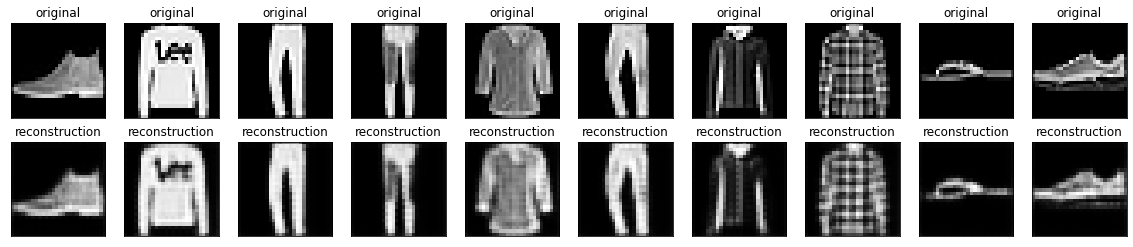

In [17]:
# Plot visualization of reconstruction from best model

with tpu_strategy.scope():
  model = Autoencoder(best)
  model.compile(optimizer='adam', loss=losses.MeanSquaredError())
  model.fit(x_train, x_train,
            epochs=10,
            shuffle=True,
            batch_size=128 * tpu_strategy.num_replicas_in_sync,
            validation_data=(x_test, x_test))
  print("Best model architecture: ")
  model.encoder.summary()
  model.decoder.summary()
reconstruction = model(x_test)

print(tf.math.reduce_sum(tf.keras.losses.MSE(x_test, reconstruction)).numpy())

n = 10
fig_img = pl.figure(figsize=(20, 4))
for i in range(n):
  
    # display original
    ax = pl.subplot(2, n, i + 1)
    pl.title("original")
    pl.imshow(tf.squeeze(x_test[i]))
    pl.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction from best model
    bx = pl.subplot(2, n, i + n + 1)
    pl.title("reconstruction")
    pl.imshow(tf.squeeze(reconstruction[i]))
    pl.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
pl.show()
fig_img.savefig('Best_model_reconstruct.png', bbox_inches='tight')